#  Verifying the XYZ to sRGB function
Wikipedia has an [article on sRGB](rom CIE XYZ to sRGB) that shows an algorithm for converting from an XYZ colour space to sRGB.

The code below demonstrates that and shows that the colour XYZ_to_sRGB function gives the same result.

Start by getting a colour from a colour checker space, which is in xyY space, converting to XYZ space and then comparing that conversion with my implmentation of the sRGB function.

There are a number of colour checkers that could be used but I am going to use "ColorChecker 1976" as I have a 2005 Greta Macbeth mini color checker that uses this scheme according to the colour specification that was supplied with it.

Note that this function renders the purple as #5e3a6d

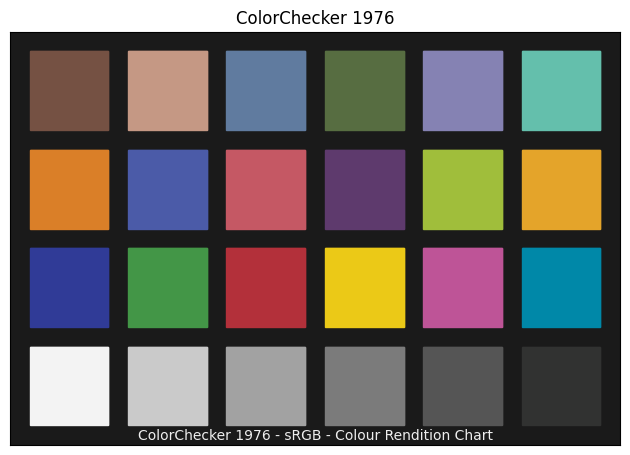

(<Figure size 640x480 with 1 Axes>,
 <AxesSubplot:title={'center':'ColorChecker 1976'}>)

In [1]:
%pip install -q colour-science
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import colour
import colour.plotting as cp 
CHECKER_VERSION = "ColorChecker 1976"
cp.plot_single_colour_checker(CHECKER_VERSION, text_kwargs={"visible": False} )

# Get one data point and convert to different colour spaces
The data is xyY space.  However most of the conversion routines are in XYZ space



In xyY space this is purple (p): [ 0.2845  0.202   0.0656]
In XYZ space this is purple (p1): [ 0.09239208  0.0656      0.1667604 ]
to Lab (p2): [ 30.78348847  28.24630135 -26.33722483]
XYZ to sRGB default (p3): [ 0.37407601  0.22221792  0.44676055]


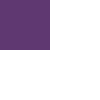

In [11]:
def rgb_to_hex(c):
    c1 = c*255
    c2 = f"#{int(c1[0]):02X}{int(c1[1]):02X}{int(c1[2]):02X}"
    return c2
cc = colour.characterisation.datasets.colour_checkers.CCS_COLOURCHECKERS

%pip install "drawsvg~=2.0"
import drawsvg as draw
def swatch(rgb_hex):
    d = draw.Drawing(100, 100, origin='center')
    # Draw a rectangle
    r = draw.Rectangle(-50, -50, 50, 50, fill=rgb_to_hex(rgb_hex))
    d.append(r)
    return d
    
p = cc[CHECKER_VERSION].data["purple"]
print(f"In xyY space this is purple (p): {p}")
p1 = colour.xyY_to_XYZ(p)
print(f"In XYZ space this is purple (p1): {p1}")
p2 = colour.XYZ_to_Lab(p1)
print(f"to Lab (p2): {p2}")
p3 = colour.XYZ_to_sRGB(p1)
print(f"XYZ to sRGB default (p3): {p3}")
swatch(p3)

Note that this method of drawing the swatch the colour matches #5f3871 the input colour.  This shows that the colour swatch method used by colour has a different rendering intent, different illuminant or something.  The colour difference is TBC 

The main conversion function is shown below from the Wikipedia page and I have also implmented the gamma function.

$$
{\displaystyle {\begin{bmatrix}R_{\text{linear}}\\G_{\text{linear}}\\B_{\text{linear}}\end{bmatrix}}={\begin{bmatrix}+3.2406&-1.5372&-0.4986\\-0.9689&+1.8758&+0.0415\\+0.0557&-0.2040&+1.0570\end{bmatrix}}{\begin{bmatrix}X_{D65}\\Y_{D65}\\Z_{D65}\end{bmatrix}}}
$$

to sRGB own function (p4): [0.3740760061089989 0.22221792497451975 0.44676055375148577] #5F3871
p4 == p3: [ True  True  True]


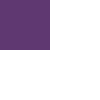

In [14]:
# Conversion matrix to linear RGB
sx = np.array([
    [+3.2406,-1.5372,-0.4986],
    [-0.9689,+1.8758,+0.0415],
    [+0.0557,-0.2040,+1.0570]])
# sRGB gamma function in linear RGB space
def gamma(l):
    if l <= 0.0031308:
        return 12.92 * l
    return (1.055* l ** (1/2.4))-0.055
# print(255*gamma(0.0031307),255*gamma(0.0031308),255*gamma(0.0031309))
# sRGB gamma function as a numpy function
ngamma = np.frompyfunc(gamma, 1, 1)
# Converting XYZ value above to sRGB
p4 = ngamma(sx @ p1)
print(f"to sRGB own function (p4): {p4} {rgb_to_hex(p4)}")
print(f"p4 == p3: {p4==p3}")
swatch(p4)

So this is proof that my conversion and the calculation are the same.  However there is still the difference of the swatch rending which may be due to a different illiumination.

In the formula this refers to D65 data and I thought the sRGB used a D50 illuminant.

Wikipedia says:

```
The sRGB specification assumes a dimly lit encoding (creation) environment with an ambient correlated color temperature (CCT) of 5003 K. This differs from the CCT of the illuminant (D65). Using D50 for both would have made the white point of most photographic paper appear excessively blue.[8][9] The other parameters, such as the luminance level, are representative of a typical CRT monitor.```